# Bathymetric Data Visualization
### Objective(s) for this notebook:
- Download a small tile from _WCS_ & attempt to make successive contours from it with a contour making function, which exports a list or set of contours in vector format
- Then, try to stich together _WCS_ tiles to create the entire Mediterranean raster
- Acquire, plot, and export contours for this stitch

In [1]:
# You can find more detail on these libraries by consulting my install script or
# visiting their page on CRAN.
library(XML)
library(ncdf4)
library(sp)
library(lattice)
library(terra)
library(downloader)
library(ggplot2)
library(directlabels)
library(rasterVis)
library(raster)
library(gdalUtilities)
library(reshape2)
library(viridis)

terra 1.7.55

Loading required package: viridisLite



In [2]:
# A File of functions I wrote for this notebook
source("contour_functions.r")

## Downloading a tile:

To give some perspective, the small area we intend to query here is $2.5$ by $2.5$ degrees and an arc minute is $\frac{1}{60}$ of a degree, so:

- At a resolution of 1/8 arc minute, there would be $8\times 60\times 2.5=1200$ samples across each axis, for a total of $1,440,000$ total samples
- At a resolution of 1/16 arc minute, there would be $24$ (twice as many) samples across each axis, for a total of $5,670,000$ total samples

In [3]:
# Set a bounding box for the Thermaic Gulf:
xmin <- 22.0
xmax <- 24.5
ymin <- 39.0
ymax <- 41.0

In [4]:
img <- get_bathymetry_tile(xmin, xmax, ymin, ymax, resx = 0.001, resy = 0.001)

Full Request URL: https://ows.emodnet-bathymetry.eu/wcs?service=wcs&version=1.0.0&request=getcoverage&coverage=emodnet:mean&crs=EPSG:4326&BBOX=22,39,24.5,41&format=image/tiff&interpolation=nearest&resx=0.001&resy=0.001

In [5]:
bathy_df <- as.data.frame(as(img, "SpatialPixelsDataFrame"))

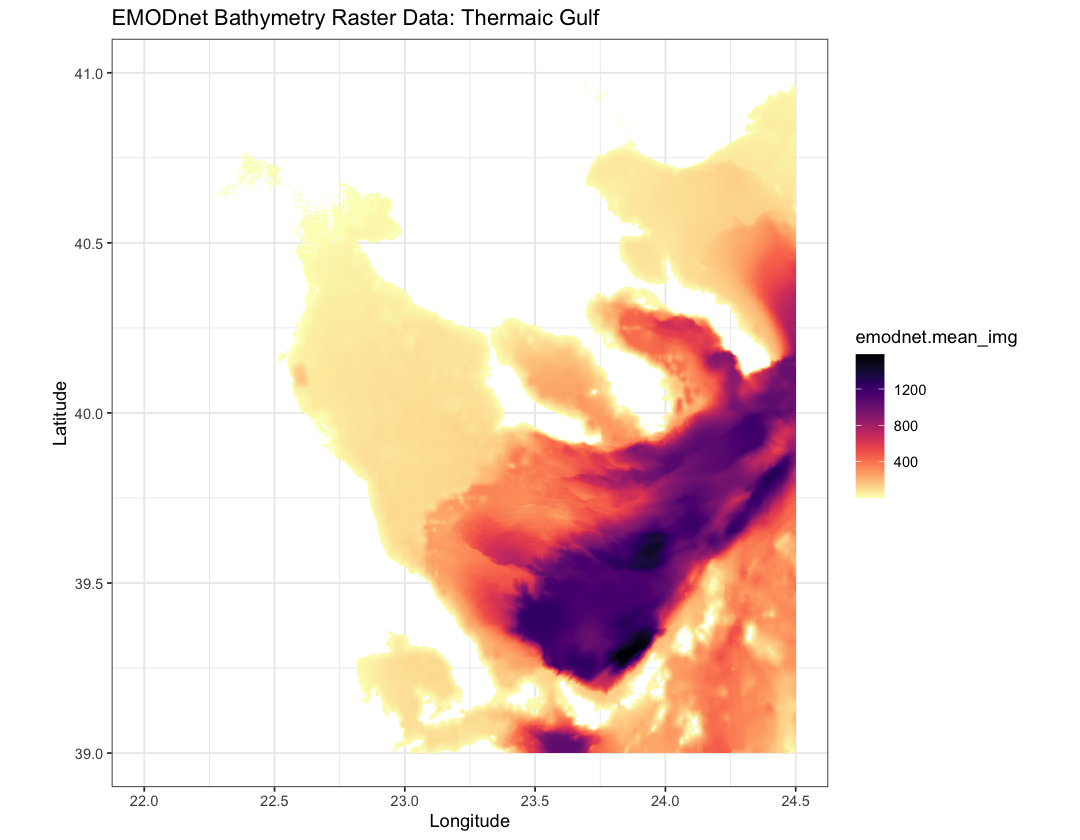

In [6]:
options(repr.plot.width = 9, repr.plot.height = 7)
map <- ggplot(aes(x = x, y = y, z = emodnet.mean_img), data = bathy_df) +
  geom_tile(data = bathy_df, aes(fill = emodnet.mean_img)) +
  #scale_fill_gradient(low = "#0097ea", high = "#1f1820", name = "Depth (m)") +
  scale_fill_viridis(option = "A", direction = -1) + # magma colormap
  coord_quickmap(xlim = range(xmin, xmax), ylim = range(ymin, ymax)) +
  ggtitle("EMODnet Bathymetry Raster Data: Thermaic Gulf") +
  xlab("Longitude") +
  ylab("Latitude") +
  theme_bw()
map

## Creating contours:

In [7]:
dim(img)

[1] 2000 2500    1

So, it appears as if the specification of `res = 0.001` $\implies$ that there are 1000 samples per degree (.001 degrees of coverage per sample).

It looks like the data frame, structured `intensity, x, y` like `bathy_df` would be much easier to stitch together than a `RasterLayer` object that doesn't have easily-accessible coordinates.

I could do this two ways,
1. I could simply collapse ranges of values (e.g `0-99.9 -> 0, 100-199.9 -> 100,...`) which would be nice because I could plot the same way.
2. Or I could export layers as a list of separate images, because what I really want in the end is several images that I can play around with and rearrange in a graphics program

## First Method:

In [8]:
img_contours <- contour_transform(img, interval = 250)

In [9]:
df_img_contours <- melt(apply(img_contours, c(2), rev), varnames = c("y", "x"), value.name = "z")

In [10]:
head(df_img_contours)

,y,x,z
,<int>,<int>,<dbl>
1,1,1,NaN
2,2,1,NaN
3,3,1,NaN
4,4,1,NaN
5,5,1,NaN
6,6,1,NaN


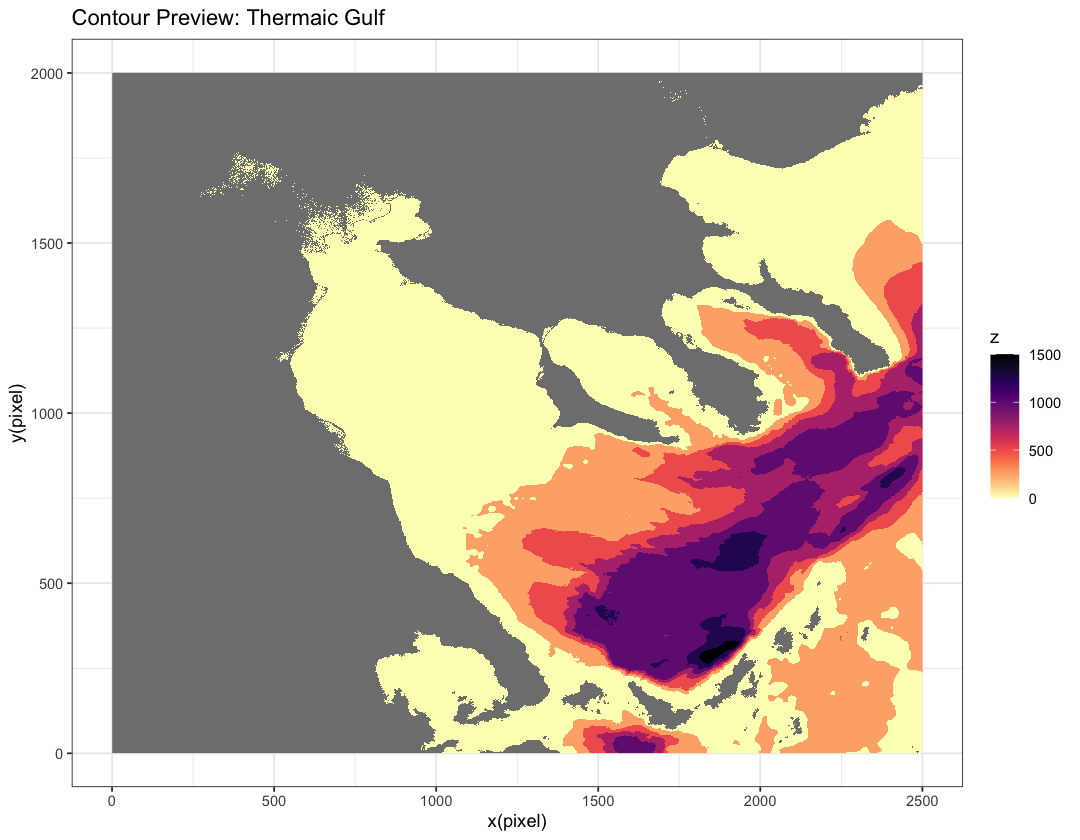

In [11]:
options(repr.plot.width = 9, repr.plot.height = 7)
map <- ggplot(aes(x = x, y = y, z = z), data = df_img_contours) +
  # geom_tile(data = bathy_df, aes(fill = emodnet.mean_img)) +
  #scale_fill_gradient(low = "#0097ea", high = "#1f1820", name = "Depth (m)") +
  geom_raster(aes(fill = z)) +
  scale_fill_viridis(option = "A", direction = -1) + # magma colormap
  # coord_quickmap(xlim = range(xmin, xmax), ylim = range(ymin, ymax)) +
  ggtitle("Contour Preview: Thermaic Gulf") +
  xlab("x(pixel)") +
  ylab("y(pixel)") +
  theme_bw()
map

## Second Method:
### Pseudocode:
```R
stitch <- function(bounding box, tile size, resolutions) {
  create matrix size of bounding box
  print resolution
  for(i in seq(start, end, resolution*tile size)) {
    for(j in similar) {
      assign box to call of get_bathymetry_tile
    }
    print msg (1/...) tiles to go!
  }
  print(deepest depth)
  return(matrix)
}

create_and_export_contour_images <- function(matrix, numContours, basin depth) {
  for(contour in numContours) {
    calculate contour depth
    create new image matrix
    use apply fn to set 
    write to tiff and export
    print msg that you are (1/n) contours of the way through
  }
}
```

The necessity of this function comes from the fact that the _WCS_ will ding you for "too large a request" (even if your resolution is quite small), so I have to look for one smaller tile at a time, and then stitch them together to create a larger picture

In [12]:
xmin <- -6
xmax <- 38
ymin <- 28
ymax <- 46
# make sure the distance in degrees in each direction is cleanly divided
# by tile_size.  I didn't write the function to work if this isn't true.

In [13]:
# Un-comment this line to fetch a stitch from EMODnet OWS using my function:
# stitched_img <- stitch_tiles(xmin, xmax, ymin, ymax, tile_size = 2, res = 100)

# Un-comment this line to store that object as a cached file.
# saveRDS(stitched_img, file = "./rcache/stitched_img.rdat")

In [14]:
# Un-comment this line to load the cached file.
stitched_img <- readRDS(file = "./rcache/stitched_img.rdat")

In [16]:
df_stitched_img <- melt(apply(stitched_img, c(2), rev),
                        varnames = c("y", "x"), value.name = "z")

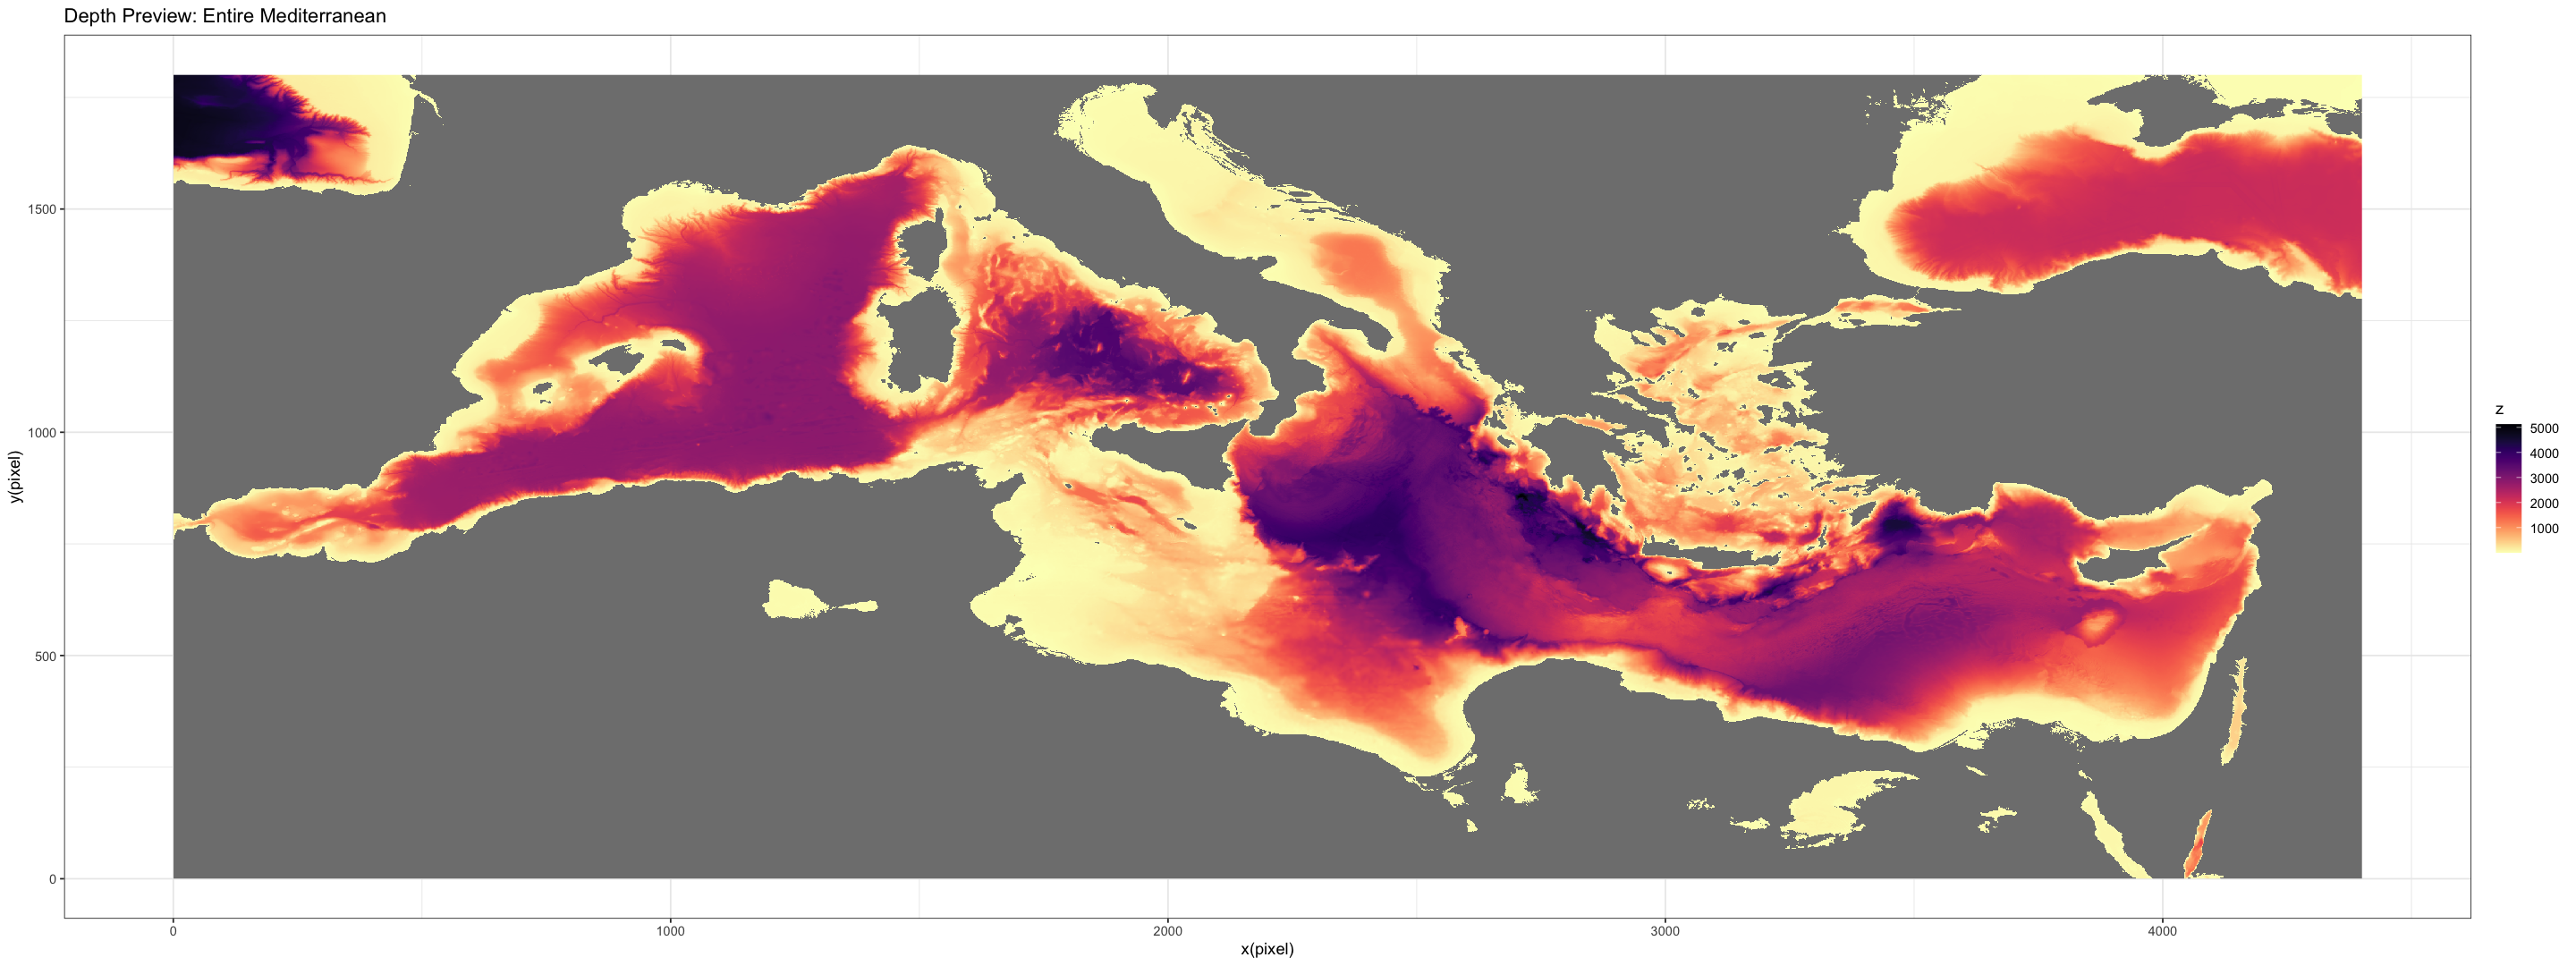

In [17]:
options(repr.plot.width = 24, repr.plot.height = 9)
map <- ggplot(aes(x = x, y = y, z = z), data = df_stitched_img) +
  geom_raster(aes(fill = z)) +
  scale_fill_viridis(option = "A", direction = -1) + # magma colormap
  ggtitle("Depth Preview: Entire Mediterranean") +
  xlab("x(pixel)") +
  ylab("y(pixel)") +
  theme_bw()
map